# フェイス検出講義 / Face Detection Lecture

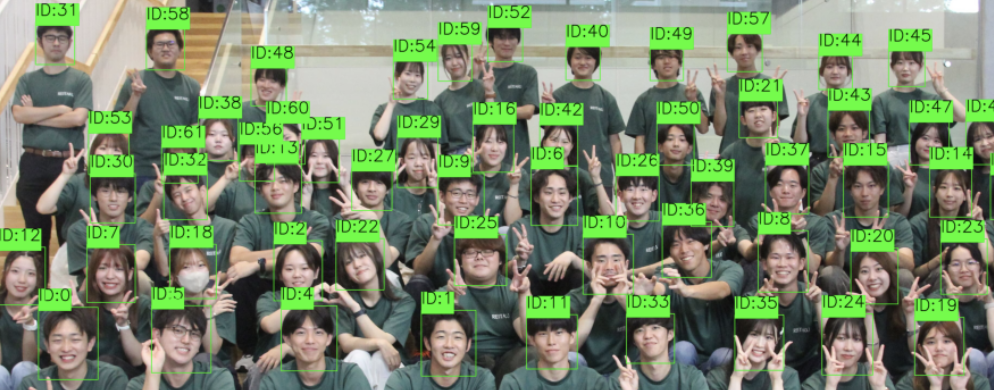

このノートでは YOLO を使った静止画の顔検出と、MTCNN での動画顔検出をさらっと体験します。顔検出 (face detection) は人の存在を確かめる基本テクニックで、単なる人混み検出よりも、その人ごとの位置や顔の表情を捉えられることに意味があります。
現場感として、校内のイベント受付で来訪者の顔を拾って入場数を記録するプロトタイプでは、YOLO を使えば数秒でフェイスボックスが出て、顔が認識できたら脈絡あるリアルタイムログが取れるという anecdote があります。

## なぜ顔検出が大事なのか / Why Face Detection Matters
- 顔検出は個々の人物単位で位置や視線を捉えるため、オンライン面談の顔トラッキングや受付での認証など『人混みをざっくり数える』よりも細かい制御ができます。
- Ultralytics YOLO (https://github.com/ultralytics/ultralytics) はリアルタイムの顔ボックス描画が得意で、追跡や顔ログを残す用途に向いています。
- MTCNN (https://github.com/ipazc/mtcnn) は小さい顔や斜め顔にも強いので、インタビュー動画で表情変化を拾う練習にぴったりです。
- 今日のデモでは、静止画に対する YOLO 対応と、ログ付きの動画プレイバックを両方触りながら、特徴的な使いどころを見ていきましょう。

## YOLO フェイス検出（概略）
- YOLO は画像全体を単一のネットワークで処理し、バウンディングボックスとクラスを同時予測する高速検出器です。
- 本ノートでは顔用に学習されたモデル（yolov8m-face 等）を使用し、検出結果を利用して加工（ぼかし／置換／コラージュ）を行います。
- 使用ライブラリ：ultralytics (YOLOv8), OpenCV, matplotlib, facenet-pytorch/mtcnn（ボーナス）。

In [ ]:
%pip install ultralytics dill opencv-python matplotlib facenet-pytorch mtcnn
# 必要なライブラリを一度にインストールします（ノートブック内で実行）。

※ `YOLO` モデルは `%pip install ...` でライブラリを入れてから使えますが、
   `yolov8m-face.pt` をノートブックルート（このリポジトリのルート）に配置しておく必要があります。
   `model_path = Path("yolov8m-face.pt")` で読み込むため、ファイルが存在しないとエラーになります。


In [ ]:
import cv2
from pathlib import Path
from ultralytics import YOLO
import matplotlib.pyplot as plt

# 画像とモデルの準備
image_path = Path("reitaku.jpg")
model_path = Path("yolov8m-face.pt")

# YOLO で高解像度推論（imgsz を指定）
model = YOLO(model_path)
result = model.predict(source=str(image_path), conf=0.25, verbose=False, imgsz=1280)[0]

# 画像読み込みと基本情報
annotated = cv2.imread(str(image_path))
h_img, w_img = annotated.shape[:2]
color = (0,255,0)
font_scale = 2
thickness = 2

# 検出結果を描画（バッファ付き）
for idx, box in enumerate(result.boxes.xyxy.cpu().numpy()):
    x1,y1,x2,y2 = map(int, box)
    w = x2 - x1; h = y2 - y1
    pad = int(max(w,h) * 0.2)  # バッファ 20%
    x1p = max(0, x1 - pad); y1p = max(0, y1 - pad)
    x2p = min(w_img, x2 + pad); y2p = min(h_img, y2 + pad)
    cv2.rectangle(annotated, (x1p,y1p), (x2p,y2p), color, thickness)
    label = f"ID:{idx}"
    (w_label, h_label), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)
    y_label = y1p-6 if y1p-6>h_label else y1p+h_label+6
    cv2.rectangle(annotated, (x1p, y_label-h_label-baseline), (x1p+w_label, y_label+baseline), color, -1)
    cv2.putText(annotated, label, (x1p, y_label-baseline), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0,0,0), thickness, cv2.LINE_AA)

# 高解像度で保存（アップスケールして保存）
output_path = Path("reitaku_yolo_faces.jpg")
annot_up = cv2.resize(annotated, (w_img*2, h_img*2), interpolation=cv2.INTER_CUBIC)
cv2.imwrite(str(output_path), annot_up)
print(f"検出された顔の数: {len(result.boxes)} faces")
plt.figure(figsize=(16,16))
plt.imshow(cv2.cvtColor(annot_up, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f'Reitaku YOLO face × {len(result.boxes)} ')
plt.show()

### Example 1: ぼかしで匿名化（Blur for anonymization）

YOLO により検出した顔領域にバッファを追加して強めにガウシアンブラーを適用します。


In [ ]:
# 顔領域を強くぼかして高解像度で保存（関数化）：blur_faces(image_path) を定義・実行
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

def blur_faces(image_path):
    """
    blur_faces(image_path): YOLO で検出して顔領域を強くぼかす関数。
    引数は image_path のみ（文字列または Path）。
    """
    image_path = Path(image_path)
    model_path = Path('yolov8m-face.pt')
    from ultralytics import YOLO
    model = YOLO(model_path)
    result = model.predict(source=str(image_path), conf=0.25, verbose=False, imgsz=1280)[0]

    # 画像を読み込む
    img = cv2.imread(str(image_path))
    if img is None:
        raise FileNotFoundError(f'Image not found: {image_path}')
    h_img, w_img = img.shape[:2]
    out = img.copy()  # 出力用にコピー

    # 検出された顔ごとに処理
    for box in result.boxes.xyxy.cpu().numpy():
        x1, y1, x2, y2 = map(int, box)
        if x2 <= x1 or y2 <= y1:
            continue  # 異常なボックスはスキップ
        w = x2 - x1
        h = y2 - y1
        pad = int(max(w, h) * 0.2)  # 顔の周囲に20%のバッファを追加
        x1p = max(0, x1 - pad)
        y1p = max(0, y1 - pad)
        x2p = min(w_img, x2 + pad)
        y2p = min(h_img, y2 + pad)
        face = out[y1p:y2p, x1p:x2p]  # 顔領域を切り出し
        if face.size == 0:
            continue  # 領域が空ならスキップ
        # ブラーのカーネルサイズを決定（顔サイズに応じて大きめに設定）
        k = max(5, min(face.shape[0], face.shape[1]) // 2)
        if k % 2 == 0:
            k += 1  # カーネルサイズは奇数にする必要あり
        # 2回ガウシアンブラーをかけて強くぼかす
        face_blur = cv2.GaussianBlur(face, (k, k), 0)
        face_blur = cv2.GaussianBlur(face_blur, (k, k), 0)
        out[y1p:y2p, x1p:x2p] = face_blur  # ぼかした顔を元画像に貼り付け

    # 画像全体を2倍にアップスケールして高解像度で保存
    up = cv2.resize(out, (w_img*2, h_img*2), interpolation=cv2.INTER_CUBIC)
    output_path = image_path.with_name(image_path.stem + '_blur_faces.jpg')
    cv2.imwrite(str(output_path), up)
    print(f'ぼかし画像を保存しました: {output_path} ')

    # 結果を表示
    plt.figure(figsize=(16,16))
    plt.imshow(cv2.cvtColor(up, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Blurred Reitaku Engineer faces')
    plt.show()

# 関数を実行（reitaku.jpg を引数として渡す）
blur_faces('reitaku.jpg')

### Example 2: 顔を画像で置き換える（Replace faces with an image）
検出顔領域（バッファ付き）を smile.png で置換します。アルファチャネル対応。

In [ ]:
# 顔領域を画像で置き換えて高解像度で保存（関数化）：replace_faces(image_path, replace_image_path) を定義・実行
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

def replace_faces(image_path, replace_image_path):
    """
    replace_faces(image_path, replace_image_path): YOLO で検出して検出領域を指定画像で置換する関数。
    引数は image_path と replace_image_path（どちらも文字列または Path）。
    """
    image_path = Path(image_path)
    replace_image_path = Path(replace_image_path)
    model_path = Path('yolov8m-face.pt')
    from ultralytics import YOLO
    model = YOLO(model_path)
    result = model.predict(source=str(image_path), conf=0.25, verbose=False, imgsz=1280)[0]

    # 置換に使う画像を確認（アルファチャネル対応 PNG を想定）
    if not replace_image_path.exists():
        raise FileNotFoundError(f'{replace_image_path} が作業ディレクトリに見つかりません')
    repl = cv2.imread(str(replace_image_path), cv2.IMREAD_UNCHANGED)
    if repl is None:
        raise FileNotFoundError(f'Failed to read replacement image: {replace_image_path}')

    img = cv2.imread(str(image_path))
    if img is None:
        raise FileNotFoundError(f'Image not found: {image_path}')
    h_img, w_img = img.shape[:2]
    out = img.copy()

    for box in result.boxes.xyxy.cpu().numpy():
        # 検出ボックスを整数化
        x1, y1, x2, y2 = map(int, box)
        if x2 <= x1 or y2 <= y1:
            continue

        # 顔サイズとバッファ（20%）を計算
        w = x2 - x1
        h = y2 - y1
        pad = int(max(w, h) * 0.2)
        x1p = max(0, x1 - pad)
        y1p = max(0, y1 - pad)
        x2p = min(w_img, x2 + pad)
        y2p = min(h_img, y2 + pad)
        w_p = max(1, x2p - x1p)
        h_p = max(1, y2p - y1p)

        # 置き換え画像が空でないか確認
        if repl.shape[1] == 0 or repl.shape[0] == 0:
            continue

        # 顔領域（バッファ込み）の大きさにリサイズ
        repl_resized = cv2.resize(repl, (w_p, h_p), interpolation=cv2.INTER_AREA)

        # アルファチャネルがある場合はブレンド
        if repl_resized.shape[2] == 4:
            alpha = repl_resized[:, :, 3] / 255.0
            for c in range(3):
                out[y1p:y2p, x1p:x2p, c] = (
                    alpha * repl_resized[:, :, c] +
                    (1 - alpha) * out[y1p:y2p, x1p:x2p, c]
                )
        else:
            out[y1p:y2p, x1p:x2p] = repl_resized[:, :, :3]

    # 仕上げに 2 倍スケールで高解像度保存（CUBIC で滑らかに拡大）
    up = cv2.resize(out, (w_img * 2, h_img * 2), interpolation=cv2.INTER_CUBIC)
    output_path = image_path.with_name(image_path.stem + '_smile_replace.jpg')
    cv2.imwrite(str(output_path), up)
    print(f'置換画像を保存しました: {output_path} ')

    # プレビュー表示
    plt.figure(figsize=(12, 12))
    plt.imshow(cv2.cvtColor(up, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Faces replaced with replacement image')
    plt.show()

# 関数を実行（reitaku.jpg を引数として渡す。置換画像は smile.png）
replace_faces('reitaku.jpg', 'smile.png')

### Example 3: 切り出した顔のコラージュ（Collage of cropped faces）
バッファを付けて顔を切り出し、正方形にパディングして同サイズのタイルでコラージュを作成します（高解像度）。

In [ ]:
# 切り出した顔のコラージュを高解像度で作成（関数化）：collage_faces(image_path) を定義・実行
import cv2
import numpy as np
from math import ceil
from pathlib import Path
import matplotlib.pyplot as plt

def collage_faces(image_path):
    """
    collage_faces(image_path): YOLO で検出して顔を切り出し、コラージュを作成する関数。
    引数は image_path のみ（文字列または Path）。
    """
    image_path = Path(image_path)
    model_path = Path('yolov8m-face.pt')
    from ultralytics import YOLO
    model = YOLO(model_path)
    result = model.predict(source=str(image_path), conf=0.25, verbose=False, imgsz=1280)[0]

    img = cv2.imread(str(image_path))
    if img is None:
        raise FileNotFoundError(f'Image not found: {image_path}')
    h_img, w_img = img.shape[:2]
    faces = []
    tile = 256

    for box in result.boxes.xyxy.cpu().numpy():
        x1, y1, x2, y2 = map(int, box)
        w = x2 - x1; h = y2 - y1
        pad = int(max(w, h) * 0.2)
        x1p = max(0, x1 - pad); y1p = max(0, y1 - pad)
        x2p = min(w_img, x2 + pad); y2p = min(h_img, y2 + pad)
        if x2p <= x1p or y2p <= y1p:
            continue
        crop = img[y1p:y2p, x1p:x2p]
        h_c, w_c = crop.shape[:2]
        size = max(h_c, w_c)
        square = np.full((size, size, 3), 255, dtype=np.uint8)
        y_off = (size - h_c)//2; x_off = (size - w_c)//2
        square[y_off:y_off+h_c, x_off:x_off+w_c] = crop
        faces.append(cv2.resize(square, (tile, tile), interpolation=cv2.INTER_AREA))

    if len(faces) == 0:
        print('コラージュ用の顔が見つかりません')
        return None

    cols = min(5, len(faces))
    rows = ceil(len(faces) / cols)
    canvas = np.full((rows*tile, cols*tile, 3), 255, dtype=np.uint8)
    for idx, f in enumerate(faces):
        r = idx // cols; c = idx % cols
        canvas[r*tile:(r+1)*tile, c*tile:(c+1)*tile] = f

    output_path = image_path.with_name(image_path.stem + '_faces_collage.jpg')
    cv2.imwrite(str(output_path), canvas)
    print(f'コラージュを保存しました: {output_path} (faces: {len(faces)})')
    plt.figure(figsize=(16,12))
    plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Faces collage ({len(faces)} faces)')
    plt.show()

# 関数を実行（reitaku.jpg を引数として渡す）
collage_faces('reitaku.jpg')

## ボーナス（末尾）: MTCNN による動画顔検出
以下はボーナス実装です。短い動画を読み込んで MTCNN で顔を検出し、最適化（フレームスキップ、スケール）をしています。

In [ ]:
# MTCNN を使った動画顔検出（ボーナス）
from pathlib import Path
import cv2
from mtcnn import MTCNN

# 動画を読み込み（ローカルに video.mp4 を置く）
video_path = Path("video.mp4")
cap = cv2.VideoCapture(str(video_path))
if not cap.isOpened():
    print("ビデオを開けませんでした")
    raise SystemExit

# 全フレームをメモリに読み込む
frames = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(frame)
cap.release()

if not frames:
    raise SystemExit("動画フレームがありません")

# MTCNN 検出器を初期化
detector = MTCNN()

window_name = "MTCNN 顔検出（ボーナス）"
cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
if hasattr(cv2, "startWindowThread"):
    cv2.startWindowThread()

# 再生制御用の変数
paused = False  # 一時停止フラグ
direction = 1  # 1=前進, -1=逆再生
current_idx = 0  # 現在のフレームインデックス
skip_frames = 10  # 検出を実行するフレーム間隔（処理負荷軽減のため）
scaled_w, scaled_h = 1280, 720  # 検出用にスケールするサイズ（高解像度）
last_dims = (frames[0].shape[1], frames[0].shape[0])  # 元の画像サイズを記録
detections_cache = {}  # フレームごとの検出結果をキャッシュ
last_detection_frame = None  # 最後に検出を実行したフレーム番号

print("操作方法: SPACE=一時停止/再開 q=終了 j=逆再生 l=前進")

try:
    while True:
        # 現在のフレームをコピー（描画用）
        frame = frames[current_idx].copy()
        
        # skip_frames ごとに顔検出を実行（パフォーマンス最適化）
        if current_idx % skip_frames == 0 and current_idx not in detections_cache:
            # フレームをスケールして検出精度を向上
            scaled = cv2.resize(frame, (scaled_w, scaled_h))
            # MTCNN で顔検出（RGB 変換が必要）
            detections_cache[current_idx] = detector.detect_faces(cv2.cvtColor(scaled, cv2.COLOR_BGR2RGB)) or []
            last_dims = (frame.shape[1], frame.shape[0])
            last_detection_frame = current_idx
            print(f"フレーム {current_idx}: {len(detections_cache[current_idx])} 個の顔を検出", flush=True)
        
        # キャッシュから検出結果を取得
        detections = detections_cache.get(current_idx)
        # キャッシュにない場合は最後の検出結果を流用
        if detections is None and last_detection_frame is not None:
            detections = detections_cache.get(last_detection_frame, [])
        
        # 検出された顔ごとにバウンディングボックスを描画
        if detections:
            # スケール比を計算（検出時のサイズと元のサイズの比率）
            width_scale = last_dims[0] / scaled_w if last_dims[0] else 1
            height_scale = last_dims[1] / scaled_h if last_dims[1] else 1
            
            for idx, detection in enumerate(detections):
                # バウンディングボックスの座標を取得
                x, y, width, height = detection['box']
                # 元の画像サイズに合わせてスケール変換
                x = max(0, int(x * width_scale))
                y = max(0, int(y * height_scale))
                width = int(width * width_scale)
                height = int(height * height_scale)
                
                # 緑色の矩形を描画（アンチエイリアス付き）
                cv2.rectangle(frame, (x, y), (x + width, y + height), (0, 255, 0), 2, cv2.LINE_AA)
                
                # 顔 ID ラベルを作成
                label = f"ID:{idx}"
                (label_w, label_h), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
                # ラベルの背景位置を計算（顔の上または下）
                y_label = y - 10 if y - 10 > label_h else y + label_h + 10
                # ラベル背景の緑色矩形を描画
                cv2.rectangle(frame, (x, y_label - label_h - baseline), (x + label_w, y_label + baseline), (0, 255, 0), -1, cv2.LINE_AA)
                # ラベルテキストを描画（黒文字）
                cv2.putText(frame, label, (x, y_label - baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2, cv2.LINE_AA)
        
        # 検出された顔の総数を表示
        face_count = len(detections) if detections else 0
        cv2.putText(frame, f"Face count: {face_count}", (20, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3, cv2.LINE_AA)
        
        # フレームを表示
        cv2.imshow(window_name, frame)
        
        # キー入力を待つ（30ms）
        key = cv2.waitKey(30) & 0xFF
        
        # 'q', 'Q', ESC で終了
        if key in (ord('q'), ord('Q'), 27):
            break
        if key == ord(' '):
            paused = not paused
        elif key == ord('j'):
            direction = -1
            paused = False
        elif key == ord('l'):
            direction = 1
            paused = False
        
        # ウィンドウが閉じられたら終了
        if cv2.getWindowProperty(window_name, cv2.WND_PROP_VISIBLE) < 1:
            break
        
        # 一時停止中でなければフレームを進める/戻す
        if not paused:
            if direction == 1:
                # 前進（最後のフレームで停止）
                current_idx = min(current_idx + 1, len(frames) - 1)
            elif direction == -1:
                # 逆再生（最初のフレームで停止）
                current_idx = max(current_idx - 1, 0)
finally:
    # GUI スレッドを閉じてウィンドウを確実に消す
    cv2.destroyAllWindows()



# 課題 / Assignment：Face Detection Notebook

今週の課題は、自分でテーマ（use case）を設定し、そのテーマに合った **顔検出アプリ** を  
**Jupyter Notebook** で作成することです。  
完成した `.ipynb` を **GitHub にコミット**し、**UNIPA に URL を提出**してください。

---

## ① テーマ（Use Case）を決める

以下は参考例。自由に発想して OK：

- 文化祭の受付で来場者をカウントする  
- 公共スペースの混雑（人数）推定  
- 体育会の集合写真からチーム人数をカウント  
- 写真の中の人物の多さ・構図の傾向を分析  
- SNS プロフィール写真の構成分析  
- 自分の研究テーマに関連した顔データ分析  

**必ず「顔が写っている画像」を 1 枚以上 Notebook に読み込み、分析すること。**

---

## ② 使用する手法

以下のいずれか、または両方を使用：

- **YOLO**（高速・リアルタイム向き）  
- **MTCNN**（精度が高く、小さい顔も検出しやすい）

Notebook 内に以下の短いコメントを追記：

- 役に立った点（強み）  
- 限界を感じた点（弱み）  

---

## ③ Notebook（.ipynb）に含める内容

### **1. 画像の読み込み**
- 自分で選んだ顔画像を読み込む  
- 複数でも OK、最低 1 枚は必須  

### **2. 顔検出コード**
- YOLO または MTCNN（または両方）  
- 検出結果を画像として表示（バウンディングボックスなど）

### **3. 検出結果の分析**
例：

- 画像に何人写っているか  
- 検出が難しかった点（小さい顔・横向き・暗所など）  
- YOLO と MTCNN の比較（使用した場合）

### **4. 所感**
- こういう場面では使えそう  
- こういう画像では精度が落ちた  
- 今回のテーマでこの技術が必要だった理由  

---

## ④ 提出方法

- VS Code で **新しい .ipynb** を作成  
  - 推奨ファイル名：`face_detection.ipynb`
- 完成した Notebook を **GitHub リポジトリにコミット**  
- GitHub 上の `.ipynb` の **URL を UNIPA に提出**  
- ※ ファイルを UNIPA に直接アップロードしないこと

---